In [1]:
import os

import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [2]:
DATA_SOURCE = "July 3 100 cm"

header_lines = 8
data_lines = 1024

prominence = 30
width = 10

In [3]:
def get_data_sets(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        total_lines = len(lines)
        total_data_sets = math.floor(total_lines / (header_lines + data_lines))
        file.close()

    return total_data_sets - 1

In [4]:
def read_data_from_file(file_path):
    animation = "|/-\\"
    tme = 0

    with open(file_path, "r") as file:
        # Skip the initial 8 header lines
        for _ in range(header_lines):
            next(file)

        # Initialize an empty list to store the data
        data = []

        # Read the data sets
        for _ in range(ds):
            # Read the data lines
            data_set = [next(file).strip().split() for _ in range(data_lines)]
            data_set = [float(item) for sublist in data_set for item in sublist]
            data.append(data_set)

            print(animation[tme % len(animation)], end="\r")
            tme += 1

            # Skip the next 8 header lines
            for _ in range(header_lines):
                next(file)

    # Convert the list of data into a NumPy array
    data_arr = np.array(data)
    return data_arr

In [5]:
all_data = []

for i, folder_name in enumerate(os.listdir("short_data")):
    if not folder_name.startswith('.'):
        trigger_file_path = "short_data/" + folder_name + "/trigger.txt"
        distant_plate_file_path = "short_data/" + folder_name + "/distant.txt"
        bottom_plate_file_path = "short_data/" + folder_name + "/bottom.txt"

        PMT_3_file = "short_data/" + folder_name + "/short_3.txt"
        PMT_4_file = "short_data/" + folder_name + "/short_4.txt"
        PMT_5_file = "short_data/" + folder_name + "/short_5.txt"
        PMT_6_file = "short_data/" + folder_name + "/short_6.txt"
        PMT_7_file = "short_data/" + folder_name + "/short_7.txt"

        ds = get_data_sets(trigger_file_path)

        all_data.append(
            [
                folder_name,  # 0
                ds,
                read_data_from_file(trigger_file_path),  # 1
                read_data_from_file(distant_plate_file_path),  # 2
                read_data_from_file(bottom_plate_file_path),  # 3
                read_data_from_file(PMT_3_file),  # 4
                read_data_from_file(PMT_4_file),  # 5
                read_data_from_file(PMT_5_file),  # 6
                read_data_from_file(PMT_6_file),  # 7
                read_data_from_file(PMT_7_file)  # 8
            ]
        )

        print(i)

0
1
3
4
5
6
7
8
9


In [6]:
def peak_area(data, channel):
    counts = data[channel]  # ADC counts
    samples = np.arange(len(counts))  # number of samples
    baseline_section = np.concatenate(
        (
            counts[:200],
            counts[-500:-30],
        )
    )  # make this so it checks that there is not a pulse here, can be now we have multiple messing with baseline
    baseline = np.median(baseline_section)  # median of the non trigger region, should be non pulse region
    baseline_std = np.std(baseline_section)  # standard deviation of baseline region

    threshold = [(baseline - 3 * baseline_std)] * len(samples)
    threshold = threshold - baseline
    counts = counts - baseline  # redefine baseline as zero

    peak, properties = find_peaks(-counts, prominence=30, width=20)
    # if len(peak) == 0:
    #   peak, properties = find_peaks(-counts, prominence=20, width=10)
    if len(peak) != 0:
        pulse_start, pulse_end = find_largest_region(counts, threshold)

        area = abs(np.trapz(counts[pulse_start:pulse_end], samples[pulse_start:pulse_end]))
    else:
        area, pulse_start, pulse_end = 0, 0, 0

    return area, samples, counts, baseline, baseline_std, threshold, pulse_start, pulse_end

In [7]:
def find_largest_region(counts, threshold):
    below_threshold_indices = np.where(np.array(counts) < threshold)[0]

    if len(below_threshold_indices) == 0:
        return None, None

    regions = []
    current_region = [below_threshold_indices[0], below_threshold_indices[0]]

    for i in below_threshold_indices[1:]:
        if i == current_region[1] + 1:
            current_region[1] = i
        else:
            regions.append(current_region)
            current_region = [i, i]

    regions.append(current_region)
    largest_region = max(regions, key=lambda region: region[1] - region[0])

    return largest_region[0], largest_region[1]

[ 10.98888452  10.98888452  10.98888452  10.98888452 227.22877009]
[195.26679099 195.26679099 195.26679099 195.26679099 247.27863971]


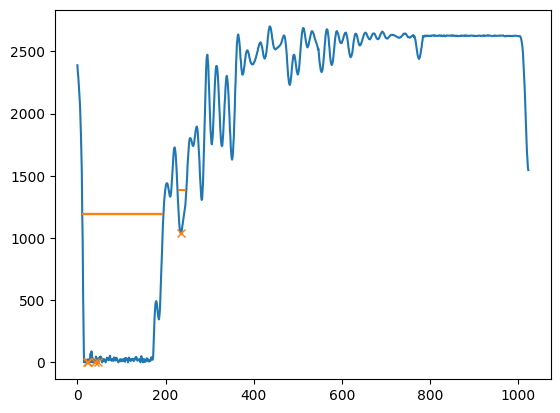

In [8]:
event = all_data[0][4][29]

peaks, properties = find_peaks(-event, prominence=30, width=20)

print(properties["left_ips"])
print(properties["right_ips"])
plt.plot(event)
plt.plot(peaks, event[peaks], "x")
plt.hlines(y=-properties["width_heights"], xmin=properties["left_ips"],
           xmax=properties["right_ips"], color="C1")
plt.show()

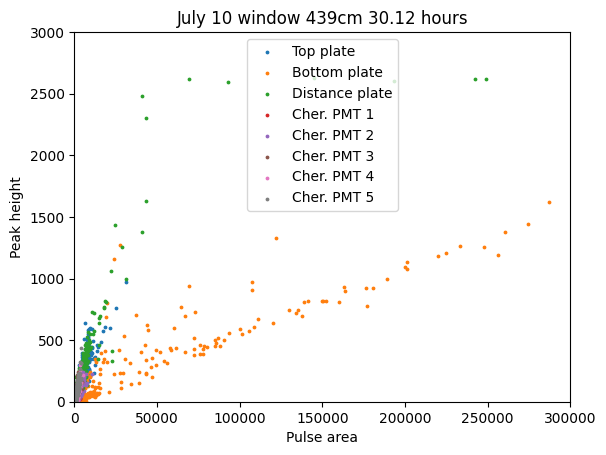

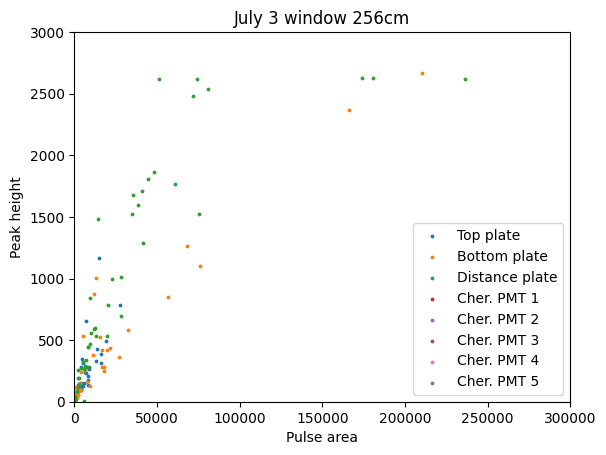

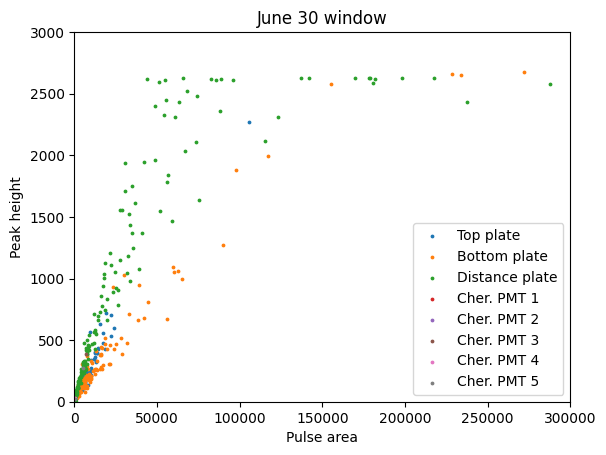

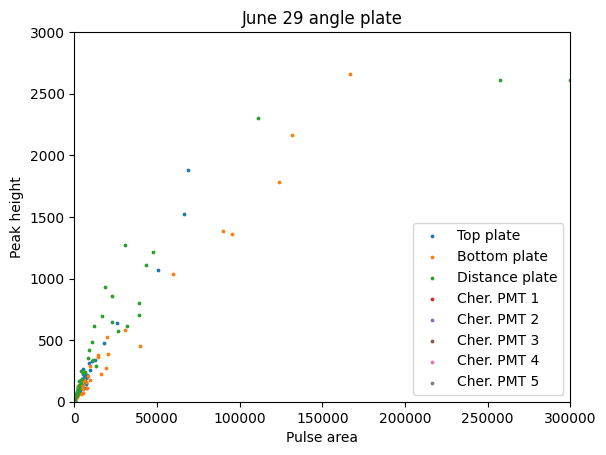

In [42]:
for data_sets in all_data[1:5]:
    for event_set in data_sets[2:]:
        area_points = []
        height_points = []
        for test, event in enumerate(event_set):
            samples = np.arange(len(event))

            baseline_section = np.concatenate(
                (
                    event[:200],
                    event[-500:-30],
                )
            )
            baseline = np.median(baseline_section)
            baseline_std = np.std(baseline_section)

            threshold = [(baseline - 3 * baseline_std)] * len(samples)
            threshold = threshold - baseline
            counts = event - baseline  # redefine baseline as zero

            peaks, properties = find_peaks(-counts, prominence=30, width=20)

            widths, index = np.unique(properties.get('widths'), return_index=True)

            if peaks.size > 0:
                for i, peak in enumerate(peaks[index]):
                    pulse_start = math.floor(properties["left_ips"][index][i])
                    pulse_end = math.ceil(properties["right_ips"][index][i])

                    area = abs(np.trapz(counts[pulse_start:pulse_end], samples[pulse_start:pulse_end]))
                    area_points.append(area)
                    height_points.append(-counts[peak])

        plt.scatter(area_points, height_points, s=3)
        plt.xlim([0, 300000])
        plt.ylim([0, 3000])
        plt.title(f'{data_sets[0]}')
        plt.legend(
            ["Top plate", "Bottom plate", "Distance plate", "Cher. PMT 1", "Cher. PMT 2", "Cher. PMT 3", "Cher. PMT 4",
             "Cher. PMT 5"])
        plt.ylabel('Peak height')
        plt.xlabel('Pulse area')

    plt.show()
